In [13]:
# 🚀 Auto-setup: installs deps + configures CFBD access
import os
import sys
from pathlib import Path

# Find _auto_setup.py regardless of current working directory
_project_root = Path(__file__ if '__file__' in globals() else '.').resolve()
# If running in notebook, find project root by looking for starter_pack
_current = Path().resolve()
_auto_setup_path = None
for parent in [_current] + list(_current.parents):
    candidate = parent / "starter_pack" / "_auto_setup.py"
    if candidate.exists():
        _auto_setup_path = candidate
        os.chdir(parent / "starter_pack")
        break

if _auto_setup_path and _auto_setup_path.exists():
    exec(open(_auto_setup_path).read())
else:
    # Fallback: try relative path
    try:
        exec(open("./_auto_setup.py").read())
    except FileNotFoundError:
        print("⚠️  Could not find _auto_setup.py. Please run from starter_pack directory.")


🔧 Notebook auto-setup complete:
  • Project root: /Users/stephen_bowman/Documents/GitHub/Script_Ohio_2.0/starter_pack
  • Requirements: /Users/stephen_bowman/Documents/GitHub/Script_Ohio_2.0/starter_pack/requirements.txt
  • Missing modules: none
  • Auto install performed: False


In [14]:

# 10_srs_adjusted_metrics.ipynb
# 📈 SRS-Based Opponent Adjustments

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

# Import starter pack configuration system
_config_dir = Path().resolve() / "config"
if str(_config_dir.parent) not in sys.path:
    sys.path.insert(0, str(_config_dir.parent))
from config.data_config import get_starter_pack_config

# Get configuration
config = get_starter_pack_config()
current_year = config.current_year
DATA_DIR = str(config.data_dir)



plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,8]


In [15]:
# 📂 Load {current_year} advanced game stats and game metadata
# Note: current_year is defined in Cell 1

game_stats = pd.read_csv(str(config.get_data_path(f"advanced_game_stats/{current_year}.csv")))
games = pd.read_csv(os.path.join(DATA_DIR, "games.csv"))

# Filter only FBS games
games = games.query("season == @current_year and home_classification == 'fbs' and away_classification == 'fbs'")
stats = games[["id"]].merge(game_stats, how="inner", left_on="id", right_on="gameId")

# Focus on FBS teams only
teams = sorted(set(stats["team"]).union(set(stats["opponent"])))
team_idx = {team: i for i, team in enumerate(teams)}
n_teams = len(teams)

print(f"{n_teams} teams included")


{"timestamp": "2025-11-25T03:02:31.872070+00:00", "level": "warning", "logger": "py.warnings", "message": "/var/folders/57/ts2cbf317_j7v99p8sk3nwjw0000gn/T/ipykernel_75340/807473351.py:5: DtypeWarning: Columns (5,6,7,10,19,29,40,61) have mixed types. Specify dtype option on import or set low_memory=False.\n  games = pd.read_csv(os.path.join(DATA_DIR, \"games.csv\"))\n", "service": "script_ohio", "environment": "development", "taskName": "Task-69"}


136 teams included


In [16]:
# Solve: offense_rating[team] - defense_rating[opponent] ≈ offense_ppa

A_off = np.zeros((n_teams, n_teams))
b_off = np.zeros(n_teams)

for _, row in stats.iterrows():
    team = row["team"]
    opp = row["opponent"]
    ppa = row["offense_ppa"]

    if team in team_idx and opp in team_idx:
        i = team_idx[team]
        j = team_idx[opp]

        A_off[i][i] += 1
        A_off[i][j] -= 1
        b_off[i] += ppa

offense_rating = np.linalg.lstsq(A_off, b_off, rcond=None)[0]

In [17]:
# Solve: defense_rating[team] - offense_rating[opponent] ≈ defense_ppa

A_def = np.zeros((n_teams, n_teams))
b_def = np.zeros(n_teams)

for _, row in stats.iterrows():
    team = row["team"]
    opp = row["opponent"]
    ppa = row["defense_ppa"]

    if team in team_idx and opp in team_idx:
        i = team_idx[team]
        j = team_idx[opp]

        A_def[i][i] += 1
        A_def[i][j] -= 1
        b_def[i] += ppa

defense_rating = np.linalg.lstsq(A_def, b_def, rcond=None)[0]

In [18]:
srs_df = pd.DataFrame({
    "team": teams,
    "offense_srs": offense_rating,
    "defense_srs": defense_rating,
    "net_srs": offense_rating - defense_rating
}).sort_values("net_srs", ascending=False)

srs_df.head(10)

,team,offense_srs,defense_srs,net_srs
86,Oregon,0.192021,-0.227551,0.419572
81,Ohio State,0.213627,-0.198765,0.412392
123,Utah,0.154551,-0.234673,0.389225
2,Alabama,0.222896,-0.152354,0.375250
79,Notre Dame,0.326439,-0.047521,0.373960
41,Indiana,0.185614,-0.187903,0.373517
60,Miami,0.161346,-0.210919,0.372265
120,USC,0.320490,-0.018303,0.338793
105,Tennessee,0.245691,-0.063685,0.309376
34,Georgia,0.220356,-0.084239,0.304594


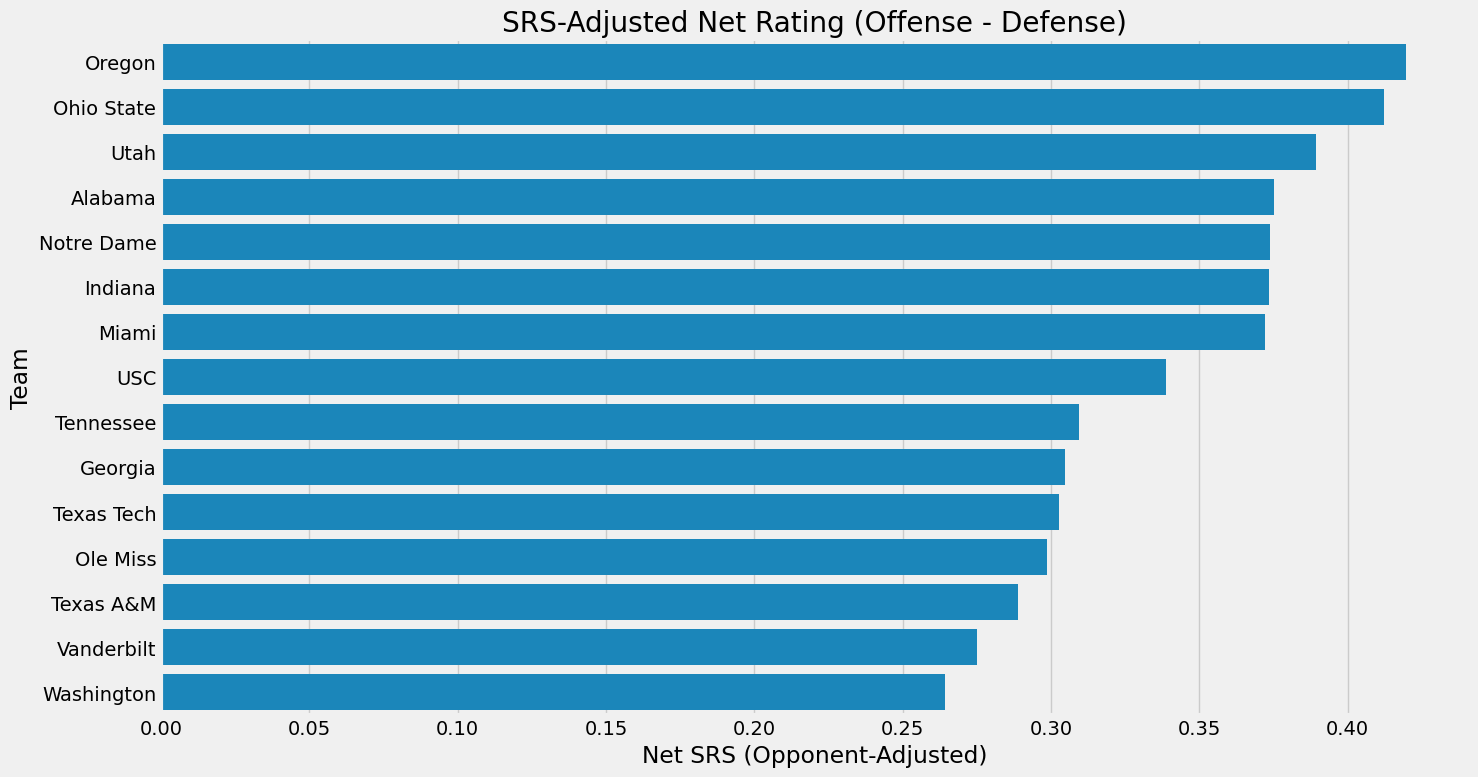

In [19]:
sns.barplot(data=srs_df.head(15), x="net_srs", y="team")
plt.title("SRS-Adjusted Net Rating (Offense - Defense)")
plt.xlabel("Net SRS (Opponent-Adjusted)")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

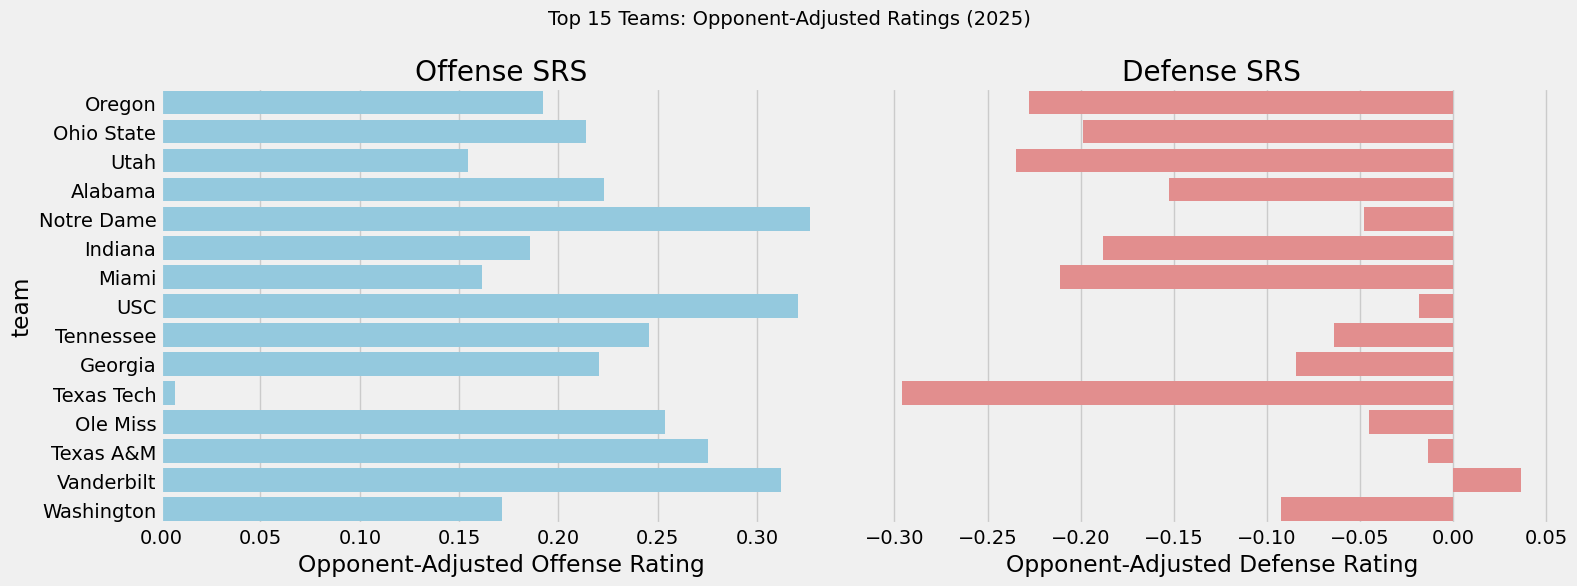

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

top = srs_df.head(15)

sns.barplot(data=top, x="offense_srs", y="team", ax=axes[0], color="skyblue")
axes[0].set_title("Offense SRS")
axes[0].set_xlabel("Opponent-Adjusted Offense Rating")

sns.barplot(data=top, x="defense_srs", y="team", ax=axes[1], color="lightcoral")
axes[1].set_title("Defense SRS")
axes[1].set_xlabel("Opponent-Adjusted Defense Rating")

plt.suptitle(f"Top 15 Teams: Opponent-Adjusted Ratings ({config.current_year})", fontsize=14)
plt.tight_layout()
plt.show()


In [21]:
# ✅ Summary

# In this notebook, you:
# - Estimated true offensive and defensive ratings using opponent-adjusted SRS
# - Solved a system of equations for each side of the ball
# - Created net ratings for overall team strength
# - Visualized and compared results across teams

# 🧪 Try This:
# - Weight games by opponent strength or margin
# - Filter to games from later in the season
# - Add tempo adjustment (EPA/play × plays/game)